# Problem set 3: Optimization and Root Finding: The Consumer Problem

We will take a look at solving the canonical utility maximization problem for the consumer.  

**Problem set structure:** 
* Each problem set consists of tasks and problems. _Tasks_ train you in using specific techniques, while _problems_ train you in solving actual economic problems. 
* Each problem set also contains solutions, which can be found in separate Python files.
* The Python files `A[..].py` do not run out of the box. But you can copy the code into your notebook or user module. 
* *You should really try to solve the tasks and problems on your own before looking at the answers!* 
* You goal should, however, not be to write everything from scratch. 
* Finding similar code from the lectures and adjusting it is completely ok. I rarely begin  completely from scratch, I figure out when I last did something similar and copy in the code to begin with. A quick peak at the solution, and then trying to write the solution yourself is also a very beneficial approach.

**Multiple solutions:** Within the field of numerical analysis there is often many more than one way of solving a specific problem. So the solution provided is just one example. If you get the same result, but use another approach, that might be just as good (or even better).

**Table of contents**<a id='toc0_'></a>    
- [1. Functions](#toc1_)    
- [2. Function continued](#toc2_)    
- [3. Methods to solve and optimize](#toc3_)    
  - [3.1 Brute‑Force Grid Search](#toc3_1_)    
  - [3.2 Bisection](#toc3_2_)    
  - [3.3 Newton's Method](#toc3_3_)    
  - [3.4 scipy.optimize](#toc3_4_)    
- [4. Other Optimizers - Comparing Methods (more difficult)](#toc4_)    
- [5. Sensitivity: Price shock](#toc5_)    
- [6. Sensitivity: Starting Values & Solver Choices](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[1. Functions](#toc0_)

Implement a Python version of this function:

$$ 
u(x_1,x_2) = (\alpha x_1^{-\beta} + (1-\alpha) x_2^{-\beta})^{-1/\beta} 
$$

In [38]:
# set autoreload so that changes in A*.py files are reflected without restarting the notebook
%load_ext autoreload
%autoreload 2

import numpy as np, time
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy import optimize


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# write your own code here
def utility_ces(x1,x2,alpha,beta):
    if x1 > 0 and x2 > 0:
        return (alpha*x1**(-beta)+(1-alpha)*x2**(-beta))**(-1/beta)

## <a id='toc2_'></a>[2. Function continued](#toc0_)

Solve the above consumer problem with the CES utility function.

$$
u(x_1,x_2) = (\alpha x_1^{-\beta} + (1-\alpha) x_2^{-\beta})^{-1/\beta}
$$

Subject to the Budget Constraint:
$$ p_1 x_1 + p_2 x_2 \le I, \quad x_1 \ge 0,\; x_2 \ge 0. $$

Tasks: Use your function from above that contains the CES utility function and embed it into another function *value_of_choice_ces* that returns the value of utility *u*.

Solve for $x_2$ subject to the budget constraint. Maybe do this with pen and paper first! Print the function with different results, what happens? 

In [ ]:
# Use these baseline parameters
alpha = 0.5
beta = 0.000001
I = 10
p1 = 1
p2 = 2


In [ ]:
# b. value-of-choice

def value_of_choice_ces(x1,alpha,beta,I,p1,p2):
    x2 = (I-p1*x1)/p2
    u = utility_ces(x1,x2,alpha,beta)
    return u

# c. objective
obj = lambda x1: -value_of_choice_ces(x1,alpha,beta,I,p1,p2)

list_x1 = [0.1, 0.5,1,2,3,4,5]
for x1 in list_x1:
    print(f"For x1 = {x1}, utility = {obj(x1)}")


For x1 = 0.1, utility = 0.7035610249656576
For x1 = 0.5, utility = 1.541102524340305
For x1 = 1, utility = 2.121319743801325
For x1 = 2, utility = 2.828426954619688
For x1 = 3, utility = 3.2403703395228733
For x1 = 4, utility = 3.464101579033822
For x1 = 5, utility = 3.535533693620822


Next, we will compare different methods to solve the consumer problem.

## <a id='toc3_'></a>[3. Methods to solve and optimize](#toc0_)

Start with 3.1, then jump to 3.4 and continue on with the Exercise set. Once completed come back to 3.2 and 3.3

### <a id='toc3_1_'></a>[3.1 Brute‑Force Grid Search](#toc0_)
Set up a grid of the budget set and solve the consumer problem on the grid.

**Idea:** Search over a grid for  $c_1 \in [0, I/p_1]$, and  $c_2 \in [0, I/p_2]$ to find the values of $c_1$ and $c_2$ that maximize utility.


Remember to have the grid_solve.py in the same folder as your current notebook

In [19]:
from types import SimpleNamespace
from grid_solve import print_solution


**Task**: Modify the grid search function below to add the additional parameter for the CES utility function $\beta$ and print the results. Note that you also need to use of the utility function. Make sure it runs below.

We now want to test for all values of of $x_1$ and $x_2$, that we can think of. This is called a brute force. We create a a grid/matrix with a large set of values and simply pick the set with the highest utility! 

Call the function, with the correct utility function

In [27]:
def find_best_choice(u_func,alpha,beta,I,p1,p2,N1,N2,do_print=True):
    
    # a. allocate numpy arrays
    shape_tuple = (N1,N2)
    x1_values = np.empty(shape_tuple)
    x2_values = np.empty(shape_tuple)
    u_values = np.empty(shape_tuple)
    
    # b. start from guess of x1=x2=0
    x1_best = 0
    x2_best = 0
    u_best = -np.inf                      # CHANGED: robust init (avoid None)

    # c. loop through all possibilities
    for i in range(N1):
        for j in range(N2):
            
            # i. x1 and x2 (chained assignment)
            x1_values[i,j] = x1 = (i/(N1-1))*I/p1
            x2_values[i,j] = x2 = (j/(N2-1))*I/p2
            
            # ii. utility
            if p1*x1 + p2*x2 <= I:  # feasible
                u_values[i,j] = u_func(x1,x2,alpha=alpha, beta=beta)  # (keep your API)
            else:                   # infeasible
                u_values[i,j] = -np.inf           # CHANGED: no call that might return None
            
            # iii. check if best so far
            if u_values[i,j] > u_best:
                x1_best = x1_values[i,j]
                x2_best = x2_values[i,j] 
                u_best = u_values[i,j]
    
    # d. print
    if do_print:
        print_solution(x1_best,x2_best,u_best,I,p1,p2)

    return SimpleNamespace(
        x1_best=x1_best, x2_best=x2_best, u_best=u_best,
        x1_values=x1_values, x2_values=x2_values, u_values=u_values
    )

In [28]:
# Run the function with the correct utility function
N1 = 100
N2 = 100

sol = find_best_choice(utility_ces, alpha, beta, I, p1, p2, N1, N2, do_print=True)


x1 = 4.9495
x2 = 2.5253
u  = 3.5354
I-p1*x1-p2*x2 = -0.00000000
x1*p1/I = 0.4949


Do you get similar results?

x1 = 4.9495
x2 = 2.5253
u  = 3.5354
I-p1*x1-p2*x2 = -0.00000000
x1*p1/I = 0.4949

### <a id='toc3_2_'></a>[3.2 Bisection](#toc0_)

Use the bisection function from the lecture. Make sure you understand what it does first. Then, define the first‑order condition of the consumer problem with the modified utility function, which we can enforce by a **single equation in $ x_1 $**:  

More help can be found in Lecture 07->02_Rootfinding_non_linear or go thorugh the uploaded lecture again!


FOC (interior):
$$\frac{\partial u/\partial x_1}{\partial u/\partial x_2}
=\frac{\alpha\,x_1^{-(\beta+1)}}{(1-\alpha)\,x_2^{-(\beta+1)}}
=\frac{\alpha}{1-\alpha}\left(\frac{x_2}{x_1}\right)^{\beta+1}
=\frac{p_1}{p_2}.$$

Single equation in $x_1$ (with $x_2(x_1)=\tfrac{I-p_1x_1}{p_2}$):
$$F(x_1)\equiv \frac{\alpha}{1-\alpha}\left(\frac{I-p_1x_1}{p_2x_1}\right)^{\beta+1}-\frac{p_1}{p_2}=0.$$

We solve $ F(x_1) = 0 $ on $[0, I/p_1]$ using **bisection**.



**Algorithm:** `bisection()`

1. Set $a_0 = a$ and $b_0 = b$ where $f(a)$ and $f(b)$ has oposite sign, $f(a_0)f(b_0)<0$
2. Compute $f(m_0)$ where $m_0 = (a_0 + b_0)/2$ is the midpoint.
3. Determine the next sub-interval $[a_1,b_1]$:
  * If $f(a_0)f(m_0) < 0$ (different signs) then $a_1 = a_0$ and $b_1 = m_0$ (i.e. focus on the range $[a_0,m_0]$).
  * If $f(m_0)f(b_0) < 0$ (different signs) then $a_1 = m_0$ and $b_1 = b_0$ (i.e. focus on the range $[m_0,b_0]$).
4. Repeat step 2 and step 3 until $|f(m_k)| < \epsilon$.

Do not alter the function bisection

In [30]:
def bisection(f, a, b, tol=1e-10, max_iter=500):
    fa, fb = f(a), f(b)
    if np.isnan(fa) or np.isnan(fb):
        raise ValueError("f(a) or f(b) is NaN.")
    if fa == 0.0: 
        return a, 0
    if fb == 0.0: 
        return b, 0
    if fa*fb > 0:
        raise ValueError("Bisection: root not bracketed. Choose a,b with opposite signs.")
    it = 0
    while (b - a) > tol and it < max_iter:
        m  = 0.5*(a + b)
        fm = f(m)
        if fm == 0.0:
            a = b = m
            break
        if fa*fm < 0:
            b, fb = m, fm
        else:
            a, fa = m, fm
        it += 1
    return 0.5*(a + b), it

Write your code in the next code block

In [32]:
# Set up the function F(c1) = 0 to solve for c1*
## write your functions here
# Budget-implied c2(c1)
def c2_of(c1, I=I, p1=p1, p2=p2):
    return (I - p1*c1)/p2

# FOC in one equation: MRS(c1) - p1/p2 = 0, where for CES
# MRS = (alpha/(1-alpha)) * (c1/c2)^(beta - 1)
def F(c1, alpha=alpha, beta=beta, I=I, p1=p1, p2=p2):
    c2 = c2_of(c1, I=I, p1=p1, p2=p2)
    # keep bisection inside the feasible open interval
    if c1 <= 0 or c2 <= 0:
        # return a sign that nudges the search back inside
        return np.sign(c1 - (I/p1)/2.0)
    return (alpha/(1.0 - alpha)) * ((c1 / c2)**(beta - 1.0)) - (p1/p2)

# Choose a bracket around the known solution
eps   = 1e-8
a_bis = eps
b_bis = I/p1 - eps

# set the tolerance and the maximum number of iterations
tol       = 1e-15
max_iter  = 500

# run the bisection method and print the solution
x1_bis, it_bis = bisection(F, a_bis, b_bis, tol=tol, max_iter=max_iter)
x2_bis = c2_of(x1_bis, I=I, p1=p1, p2=p2)
print(f"Bisection: x1*={x1_bis:.10f}, x2*={x2_bis:.10f}, iterations={it_bis}")

Bisection: x1*=5.0000017329, x2*=2.4999991336, iterations=53


In [ ]:
# import importlib, A3_2
# importlib.reload(A3_2)   # pick up the change

Bisection: x1*=5.0000017329, x2*=2.4999991336, iterations=53


<module 'A3_2' from 'c:\\Users\\jfn232\\Dropbox\\CPH\\01_Teaching\\winter_term25\\ProgEcon-exercises-private\\PS_Optimization\\A3_2.py'>

### <a id='toc3_3_'></a>[3.3 Newton's Method](#toc0_)

Apply Newton on $ F(c_1)=0 $ where $F$ is defined above.  
We compute $ F'(c_1)$ analytically for the CES consumer problem:

**Fully expanded form**
$
F'(c_1)\;=\;-\;\frac{\alpha}{1-\alpha}\,(\beta+1)\,\frac{I}{p_2\,c_1^{2}}
\left(\frac{I-p_1 c_1}{p_2\,c_1}\right)^{\beta}.
$

In [34]:
### Write your code here ###

## Hint: use F from the exercise above, define Fprime (the expanded form from above) as a function,
#  and use the Newton function from the lecture.

def c2_of(c1, I=I, p1=p1, p2=p2):
    return (I - p1*c1)/p2

# FOC as single equation:
def F(c1, alpha=alpha, beta=beta, I=I, p1=p1, p2=p2):
    c2 = c2_of(c1, I=I, p1=p1, p2=p2)
    if c1 <= 0 or c2 <= 0:
        return np.sign(c1 - (I/p1)/2.0)  # keep search interior
    return (alpha/(1.0 - alpha)) * ((c2 / c1)**(beta + 1.0)) - (p1/p2)

# Analytic derivative:
# F'(x1) = - (alpha/(1-alpha)) * (beta+1) * [ I / (p2 * x1^2 ) ] * (x2/x1)^{beta}
def Fprime(x1, alpha=alpha, beta=beta):
    c2 = c2_of(x1)                       # <- fixed (was x2_of)
    if x1 <= 0 or c2 <= 0:
        return -1.0
    s = alpha / (1.0 - alpha)
    return - s * (beta + 1.0) * (I / (p2 * x1**2)) * ((c2 / x1)**beta)

# Minimal Newton solver
def find_root(x0, f, df, tol=1e-12, max_iter=200):
    x = float(x0)
    for it in range(1, max_iter+1):
        fx, dfx = f(x), df(x)
        if not np.isfinite(fx) or not np.isfinite(dfx) or dfx == 0:
            x = 0.5*(x + 0.5*I/p1)  # gentle fallback
            continue
        x_new = x - fx/dfx
        if x_new <= 0 or x_new >= I/p1 or not np.isfinite(x_new):
            x_new = 0.5*(x + 0.5*I/p1)
        if abs(x_new - x) < tol:
            return x_new, it
        x = x_new
    return x, max_iter

# Run Newton
x0 = 0.4 * (I/p1)
x1_newt, it_newt = find_root(x0, F, Fprime, tol=1e-12)
x2_newt = c2_of(x1_newt)

print(f"Newton: x1*={x1_newt:.10f}, x2*={x2_newt:.10f}, iterations={it_newt}")


Newton: x1*=4.9999982671, x2*=2.5000008664, iterations=6


In [ ]:
# import importlib, A3_3
# importlib.reload(A3_3)   # pick up the change 

Newton: x1*=4.9999982671, x2*=2.5000008664, iterations=6


<module 'A3_3' from 'c:\\Users\\jfn232\\Dropbox\\CPH\\01_Teaching\\winter_term25\\ProgEcon-exercises-private\\PS_Optimization\\A3_3.py'>

### <a id='toc3_4_'></a>[3.4 scipy.optimize](#toc0_)

Solve the consumer problem now using the scipy.minimize_scalar function. Define adequate bounds.

Define an objective function! Then minimize it. Do it by calling the minimize_scaler from the optimize package. Since we are solving for single value, we can use the $minimize_scalar$. If we are solving for more parameters, i.e, both $x_1$ and $x_2$, we would have to write up the full minimize function. 

Help can be found in Lectures -> 07_Opti -> O1_Optimazation


In [ ]:
def value_of_choice_ces(x1,alpha,beta,I,p1,p2):
    x2 = (I-p1*x1)/p2
    u = utility_ces(x1,x2,alpha,beta)
    return u

# c. objective
obj = lambda x1: -value_of_choice_ces(x1,alpha,beta,I,p1,p2)

# d. solve
solution = optimize.minimize_scalar(obj,bounds=(0,I/p1))

# e. result
u_ces = -solution.fun
x1_ces = solution.x
x2_ces = (I-x1_ces*p1)/p2
print(x1_ces,x2_ces,u_ces)

4.99995818905239 2.500020905473805 3.535533693620822



## <a id='toc4_'></a>[4. Other Optimizers - Comparing Methods (more difficult)](#toc0_)

Solve the problem now with *SLSQP* and compare the number of iterations, function evaluations, speed, and precision with *Nelder-Mead*.

The first part of the answer is just a way to compare. When looking at the answer, there is a time function. This just measures the time it takes to run it. Time is a valueable asset when running larger models in for larger projects(eg. your thesis or seminar papers)


In [ ]:
def c2_of(x1):
    return (I - p1*x1) / p2

# closed-form optimum for a precision check
kappa   = ((p1/p2) * (1 - alpha) / alpha) ** (1.0 / (beta + 1.0))   # x2/x1
x1_star = I / (p1 + p2 * kappa)

# objective along the budget line (penalize infeasible points)
def obj(x, alpha, beta):
    x1 = float(x[0])
    x2 = c2_of(x1)
    if x1 <= 0 or x1 >= I/p1 or x2 <= 0:
        return 1e12
    return -utility_ces(x1, x2, alpha, beta)

x0 = np.array([I / (2 * p1)])

# SLSQP (bounded)
t0 = time.perf_counter()
res_slsqp = optimize.minimize(
    obj, x0=x0, args=(alpha, beta),
    bounds=[(eps, I/p1 - eps)], method="SLSQP"
)
t1 = time.perf_counter()
x1_s = float(res_slsqp.x[0]); x2_s = c2_of(x1_s)
print(
    f"SLSQP       x1*={x1_s:.10f}  "
    f"u={utility_ces(x1_s, x2_s, alpha, beta):.10f}  "
    f"nit={res_slsqp.nit}  nfev={res_slsqp.nfev}  time={(t1-t0)*1e3:.1f} ms  "
    f"error={abs(x1_s - x1_star):.2e}"
)

# Nelder–Mead (unconstrained; same penalized objective)
t0 = time.perf_counter()
res_nm = optimize.minimize(obj, x0=x0, args=(alpha, beta), method="Nelder-Mead")
t1 = time.perf_counter()
x1_n = float(res_nm.x[0]); x2_n = c2_of(x1_n)
print(
    f"Nelder-Mead x1*={x1_n:.10f}  "
    f"u={utility_ces(x1_n, x2_n, alpha, beta):.10f}  "
    f"nit={res_nm.nit}  nfev={res_nm.nfev}  time={(t1-t0)*1e3:.1f} ms  "
    f"error={abs(x1_n - x1_star):.2e}"
)

In [ ]:
# import importlib, A4
# importlib.reload(A4)   # pick up the change

SLSQP       x1*=5.0000000000  u=3.5355336936  nit=1  nfev=2  time=0.7 ms  error=1.73e-06
Nelder-Mead x1*=5.0000000000  u=3.5355336936  nit=13  nfev=26  time=1.0 ms  error=1.73e-06


<module 'A4' from 'c:\\Users\\jfn232\\Dropbox\\CPH\\01_Teaching\\winter_term25\\ProgEcon-exercises-private\\PS_Optimization\\A4.py'>

## <a id='toc5_'></a>[5. Sensitivity: Price shock](#toc0_)

- Now, assume that the price p1 doubles. Recompute (x1_star, x2_star, u_star) for each $\beta$.
- For each $\beta$, compute percentage changes relative to baseline.
- Plot two panels, where panel A contains quantities (the percentage change in x1_star and x2_star) and panel B contains the percentage change in u_star.
- Interpretation: Briefly explain how the substitution elasticity (lower beta) shapes x1_star, x2_star, and the utility.

Try for yourselves, but otherwise look at the answer

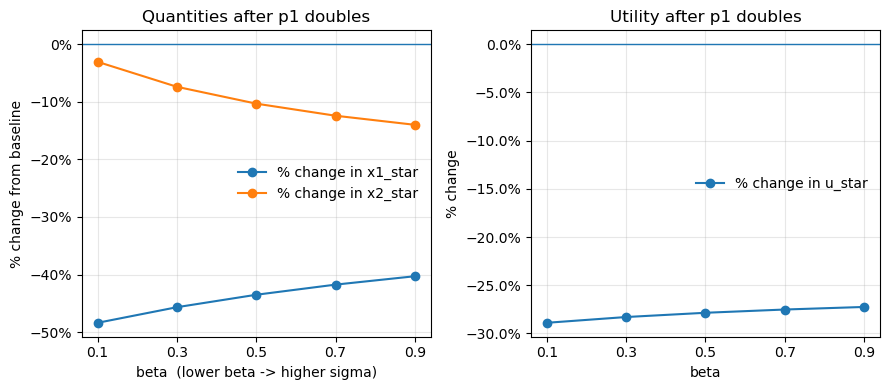

In [ ]:
betas = np.array([0.1, 0.3, 0.5, 0.7, 0.9])  # five beta values in (0,1)

# ----- helpers -----
def sigma_from_beta(beta):
    # elasticity of substitution
    return 1.0 / (1.0 + beta)

def ces_demands(I, p1, p2, alpha, beta):
    """
    Returns (x1_star, x2_star, u_star, s1, s2) using CES duality.

    Indirect utility: u_star = I / C(p),
    where C(p) = [ alpha^sigma * p1^(1 - sigma) + (1 - alpha)^sigma * p2^(1 - sigma) ]^(1 / (1 - sigma))

    Budget shares:
      s1 = alpha^sigma * p1^(1 - sigma) / denom
      s2 = 1 - s1
    """
    sigma = sigma_from_beta(beta)
    denom = (alpha**sigma) * (p1**(1.0 - sigma)) + ((1.0 - alpha)**sigma) * (p2**(1.0 - sigma))
    s1 = (alpha**sigma) * (p1**(1.0 - sigma)) / denom
    s2 = 1.0 - s1
    x1 = (I / p1) * s1
    x2 = (I / p2) * s2
    C  = denom**(1.0 / (1.0 - sigma))
    u  = I / C
    return x1, x2, u, s1, s2

# ----- baseline vs. shock (p1 doubles) -----
base = np.array([ces_demands(I, p1,p2, alpha, b) for b in betas]).T
shck = np.array([ces_demands(I, 2.0*p1, p2, alpha, b) for b in betas]).T

x1_b, x2_b, u_b = base[0], base[1], base[2]
x1_s, x2_s, u_s = shck[0], shck[1], shck[2]

pct = lambda new, old: 100.0 * (new - old) / old
d_x1 = pct(x1_s, x1_b)
d_x2 = pct(x2_s, x2_b)
d_u  = pct(u_s,  u_b)

# ----- plots -----

# plots
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)

# Panel A: quantities
axs[0].plot(betas, d_x1, marker='o', label='% change in x1_star')
axs[0].plot(betas, d_x2, marker='o', label='% change in x2_star')
axs[0].set_title('Quantities after p1 doubles')
axs[0].set_xlabel('beta  (lower beta -> higher sigma)')
axs[0].set_ylabel('% change from baseline')
axs[0].axhline(0, linewidth=1)
axs[0].yaxis.set_major_formatter(PercentFormatter())
axs[0].set_xticks(betas.tolist())
axs[0].grid(True, alpha=0.3)
axs[0].legend(frameon=False)

# Panel B: utility
axs[1].plot(betas, d_u, marker='o', label='% change in u_star')
axs[1].set_title('Utility after p1 doubles')
axs[1].set_xlabel('beta')
axs[1].set_ylabel('% change')
axs[1].axhline(0, linewidth=1)
axs[1].yaxis.set_major_formatter(PercentFormatter())
axs[1].set_xticks(betas.tolist())
axs[1].grid(True, alpha=0.3)
axs[1].legend(frameon=False)

plt.tight_layout()
plt.show()

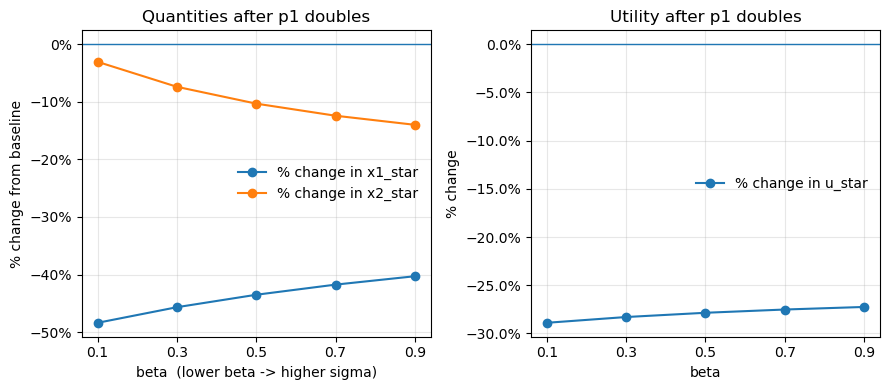

<module 'A5' from 'c:\\Users\\jfn232\\Dropbox\\CPH\\01_Teaching\\winter_term25\\ProgEcon-exercises-private\\PS_Optimization\\A5.py'>

In [ ]:
# import importlib, A5
# importlib.reload(A5)   # pick up the change

## <a id='toc6_'></a>[6. Sensitivity: Starting Values & Solver Choices](#toc0_)

- Try different starting values for Newton and `minimize`.
- Discuss your main observations and take-aways regarding number of iterations and function evaluations.
- Which one was your favorite solver in this application? Why?


Use most of your time on the solver. Make sure, you understand this. Try writing it with different $x_0$, different tolerance etc. 

In [41]:

# Try out and discuss